In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
from tensorflow.keras.layers import MaxPool2D, Conv2D, Dropout, BatchNormalization
import os

In [ ]:
# Replace the following with your secrets
os.environ['KAGGLE_USERNAME'] = "gideonoba"
os.environ['KAGGLE_KEY'] = "a5c59a043d6cdef9c5b4690f998ea4e3"

In [ ]:
import kaggle

In [ ]:
DATA_DIR = "/content/FERplus2016/FER2013"
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge -p DATA_DIR

 85% 78.0M/92.0M [00:00<00:00, 64.3MB/s]
100% 92.0M/92.0M [00:00<00:00, 157MB/s] 
  0% 0.00/7.01k [00:00<?, ?B/s]
100% 7.01k/7.01k [00:00<00:00, 7.34MB/s]
 67% 13.0M/19.3M [00:00<00:00, 44.2MB/s]
100% 19.3M/19.3M [00:00<00:00, 64.5MB/s]
 76% 59.0M/77.3M [00:00<00:00, 48.8MB/s]
100% 77.3M/77.3M [00:00<00:00, 115MB/s] 
 87% 84.0M/96.6M [00:00<00:00, 72.6MB/s]
100% 96.6M/96.6M [00:00<00:00, 110MB/s] 


In [ ]:
def create_dataset():
    # clone repo
    !git clone https://github.com/microsoft/FERPlus.git
    !mkdir ./FER2013plus
    # Extract the downloaded data into another directory
    !tar xvzf "/content/DATA_DIR/fer2013.tar.gz" -C "/content/FER2013plus/"
    # Run the data generation script on the extracted data
    !python /content/FERPlus/src/generate_training_data.py -d /content/FERPlus/data -fer "/content/FER2013plus/fer2013/fer2013.csv" -ferplus "/content/FERPlus/fer2013new.csv"
create_dataset()

Cloning into 'FERPlus'...
remote: Enumerating objects: 128, done.
remote: Total 128 (delta 0), reused 0 (delta 0), pack-reused 128
Receiving objects: 100% (128/128), 650.37 KiB | 14.45 MiB/s, done.
Resolving deltas: 100% (70/70), done.
fer2013/fer2013.csv
fer2013/README
fer2013/fer2013.bib
fer2013/
Start generating ferplus images.
Done...


In [ ]:
col_names = ["usage","img_name", "neutral","happiness","surprise","sadness","anger","disgust","fear","contempt","Unknown", "NF"]
di = {'neutral': 0, 'happiness': 1,'surprise': 2,'sadness': 3,'anger': 4,'disgust': 5,'fear': 6,'contempt': 7,'Unknown': 8,'NF': 9}
df = pd.read_csv('/content/FERPlus/fer2013new.csv',names=col_names,header=None,skiprows = 1)
print(df.shape)

(35887, 12)


In [ ]:
df_copy = df.copy()
useful_cols = [x for x in df_copy.columns][2:]
dfc = df_copy[useful_cols]
dfc['emotion'] = dfc.idxmax(axis=1)
df_final = pd.concat([df_copy[['usage','img_name']],  dfc[['emotion']]], axis=1, ignore_index=False)
df_final['img_name'] = df_final['img_name'].apply(str)
df_final = df_final.replace('nan', np.nan)
df_final.dropna(subset = ["img_name"], inplace=True)
df_final = df_final.reset_index(drop=True)

df_final['emotion'] = df_final['emotion'].map(di)
df_final['emotion'] = df_final['emotion'].apply(str)

df_final

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,usage,img_name,emotion
0,Training,fer0000000.png,0
1,Training,fer0000001.png,0
2,Training,fer0000002.png,0
3,Training,fer0000003.png,0
4,Training,fer0000004.png,0
...,...,...,...
35709,PrivateTest,fer0035796.png,0
35710,PrivateTest,fer0035797.png,0
35711,PrivateTest,fer0035799.png,4
35712,PrivateTest,fer0035800.png,1


In [ ]:
def process_df(folder_df):
  use_cols = [x for x in folder_df.columns][2:]
  folder_df['emotion'] = folder_df[use_cols].idxmax(axis=1)
  folder_df = folder_df[['img_name','emotion']]
  folder_df['emotion'] = folder_df['emotion'].map(di)
  folder_df['emotion'] = folder_df['emotion'].apply(str)
  return folder_df

new_col_names = ["img_name","size", "neutral","happiness","surprise","sadness","anger","disgust","fear","contempt","Unknown", "NF"]
train_df =  pd.read_csv('/content/FERPlus/data/FER2013Train/label.csv',names=new_col_names,header=None)
test_df =  pd.read_csv('/content/FERPlus/data/FER2013Test/label.csv',names=new_col_names,header=None)
valid_df =  pd.read_csv('/content/FERPlus/data/FER2013Valid/label.csv',names=new_col_names,header=None)

train_df = process_df(train_df)
test_df = process_df(test_df)
valid_df = process_df(valid_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(48, 48, 3)


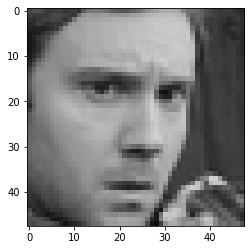

In [ ]:
# Preview image
img = cv2.imread('/content/FERPlus/data/FER2013Train/fer0000000.png')
plt.imshow(img)
print(img.shape)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1/255,
                              rotation_range=5,
                              shear_range=0.1,
                              zoom_range=0.1,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              horizontal_flip=True,
                              fill_mode='nearest'
                              )


train_generator=datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="./FERPlus/data/FER2013Train",
    x_col="img_name",
    y_col="emotion",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(48,48))

valid_datagen = ImageDataGenerator(rescale=1/255)
valid_generator=valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory="./FERPlus/data/FER2013Valid",
    x_col="img_name",
    y_col="emotion",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(48,48))

test_datagen = ImageDataGenerator(rescale=1/255)
test_generator=test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="./FERPlus/data/FER2013Test",
    x_col="img_name",
    y_col="emotion",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(48,48))


Found 28558 validated image filenames belonging to 10 classes.
Found 3579 validated image filenames belonging to 10 classes.
Found 3573 validated image filenames belonging to 9 classes.


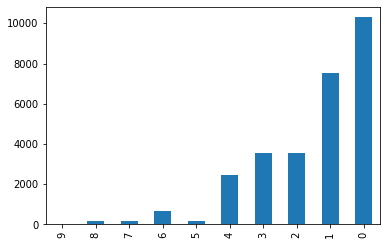

In [ ]:
train_df.emotion.value_counts().sort_index(ascending=False).plot(kind='bar')

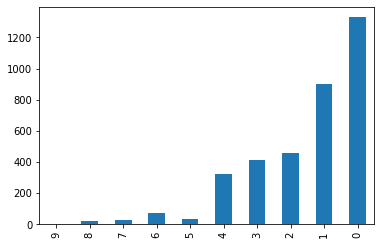

In [ ]:
valid_df.emotion.value_counts().sort_index(ascending=False).plot(kind='bar')

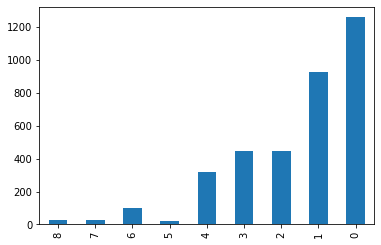

In [ ]:
test_df.emotion.value_counts().sort_index(ascending=False).plot(kind='bar')

## Transfer learning

In [ ]:
resNet50V2_model=tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(48,48,3),
    pooling=None,
    classes=10,
    classifier_activation="softmax",
)
resNet50V2_model.trainable = True

94683136/94668760 [==============================] - 1s 0us/step


In [ ]:
resNet50V2_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 26, 26, 64)   0           ['conv1_conv[0][0]']             
                                                                                         

In [ ]:
from keras import Sequential
from keras.layers import Dense,Flatten
np.random.seed(42)
tf.random.set_seed(42)

model = Sequential([
    resNet50V2_model
])
model.add(Conv2D(512, kernel_size=(1,1), activation='relu'))
model.add(MaxPool2D((2,2), strides=2, padding='same'))
model.add(Dropout(0.5))
    
model.add(Conv2D(512, kernel_size=(1,1), activation='relu'))
model.add(MaxPool2D((2,2), strides=2, padding='same'))
model.add(Dropout(0.5))
    
model.add(Dense(512, activation='relu'))
  
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.summary()

learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(), 
              metrics = ['accuracy'])
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 conv2d (Conv2D)             (None, 2, 2, 512)         1049088   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 1, 1, 512)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 1, 1, 512)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 1, 512)         262656    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 1, 1, 512)        0         
 2D)                                                    

In [ ]:
history = model.fit(x = train_generator,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_generator,
          validation_steps = STEP_SIZE_VALID,
          epochs = 20)

Epoch 1/20
892/892 [==============================] - 77s 69ms/step - loss: 1.6682 - accuracy: 0.3825 - val_loss: 1.3122 - val_accuracy: 0.5580
Epoch 2/20
892/892 [==============================] - 58s 65ms/step - loss: 1.2507 - accuracy: 0.5805 - val_loss: 1.0569 - val_accuracy: 0.6568
Epoch 3/20
892/892 [==============================] - 58s 65ms/step - loss: 1.0616 - accuracy: 0.6453 - val_loss: 0.9617 - val_accuracy: 0.6923
Epoch 4/20
892/892 [==============================] - 58s 65ms/step - loss: 0.9684 - accuracy: 0.6788 - val_loss: 0.8777 - val_accuracy: 0.7095
Epoch 5/20
892/892 [==============================] - 58s 65ms/step - loss: 0.9007 - accuracy: 0.6996 - val_loss: 0.8247 - val_accuracy: 0.7289
Epoch 6/20
892/892 [==============================] - 58s 65ms/step - loss: 0.8452 - accuracy: 0.7161 - val_loss: 0.7635 - val_accuracy: 0.7458
Epoch 7/20
892/892 [==============================] - 58s 65ms/step - loss: 0.8114 - accuracy: 0.7301 - val_loss: 0.7676 - val_accuracy:

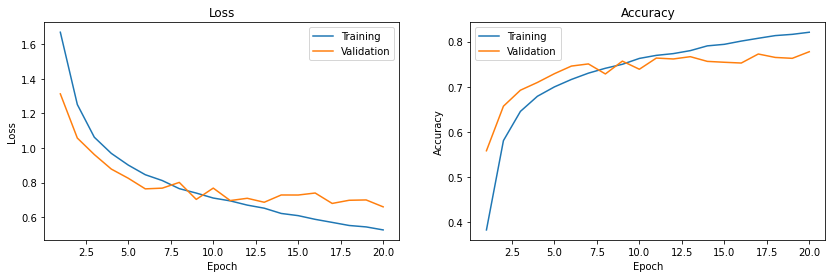

In [ ]:
history = history.history
n_epochs = len(history['loss'])

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(range(1, n_epochs+1), history['loss'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1, n_epochs+1), history['accuracy'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
# The test_dataset has only 9 classes instead of 10 this will thrown an error.
# model.evaluate(test_generator)

In [ ]:
# save and quantize model
model.save('./emotion_gideon_RESNETV2.h5')
model = tf.keras.models.load_model('./emotion_gideon_RESNETV2.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("emotion_gideon_RESNETV2.tflite", "wb").write(tflite_model)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


INFO:tensorflow:Assets written to: /tmp/tmped8gy3q5/assets


100421332

## Testing

In [ ]:
df_final_test_generator=test_datagen.flow_from_dataframe(
    dataframe=df_final,
    directory="./FERPlus/data/FER2013Test",
    x_col="img_name",
    y_col="emotion",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(48,48))

Found 3574 validated image filenames belonging to 10 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 32140 invalid image filename(s) in x_col="img_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
model.evaluate(df_final_test_generator)

112/112 [==============================] - 4s 26ms/step - loss: 0.6889 - accuracy: 0.7680


[0.6889461874961853, 0.768047034740448]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# test_probs = model.predict(df_final_test_generator)
# print(test_probs.shape)
# test_pred = np.argmax(test_probs, axis=1)
# # validate_filenames

(3574, 10)


In [ ]:
# test_labels = df_final.copy()

In [ ]:
# from sklearn.metrics import classification_report
# # test_labels = test_labels.loc[test_labels['Usage'].isin(['PublicTest', 'PrivateTest'])]
# test_labels = test_labels.loc[test_labels['usage'].isin(['PrivateTest'])]


# test_labels['emotion'] = test_labels['emotion'].apply(int)

# test_labels['predictions'] = test_pred

# my_classification_report = classification_report(test_labels['emotion'], test_labels['predictions'])
# print(my_classification_report)

# print('Total Wrong Predictions:', np.sum(test_labels['emotion'] != test_labels['predictions']))
# print('Total correct Predictions:', np.sum(test_labels['emotion'] == test_labels['predictions']))

# # scikitplot.metrics.plot_confusion_matrix(test_labels['emotion'], test_labels['predictions'], figsize=(7,7))    
